In [10]:
import os
import pandas as pd
import pathlib
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import seaborn as sns

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from ast import literal_eval
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from presolve_datasets import *
from networks import *

%load_ext tensorboard
%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [ ]:
writer = SummaryWriter(f'runs/cartpole-{time.strftime("%Y%m%d-%H%M%S")}')
%tensorboard --logdir=runs

## Define Dataset and DataLoader

In [9]:
path = 'data/presolves/cartpole_DIRCOL_5000.csv'
train_data = NLPDataset(path, train=True)
test_data = NLPDataset(path, train=False)

train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

params, Z = next(iter(train_dataloader))

In [20]:
test_data_length = len(train_data)
print(test_data_length)

4000


In [13]:
cartpole_data = NLPDataset(path, train=True)
cartpole_data.n_params
cartpole_data.n_traj
# cartpole_data.df['X'].iloc[0].shape[0]

204

In [13]:
model = CartpoleNN(train_data.n_params, train_data.n_traj).to(device)
print(f"Model structure: {model}\n\n")

# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")


Model structure: CartpoleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=204, bias=True)
  )
)




## Training Loop

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    train_loss = 0
    for batch, (X,y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    train_loss /= len(dataloader)
    # loss, current = loss.item(), batch * len(X)
    # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return train_loss
            


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches # average loss per batch
    # print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")


    return test_loss



In [15]:
learning_rate = 5e-3
batch_size = 64
epochs = 100

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

for t in tqdm(range(epochs)):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    scheduler.step()
    writer.add_scalar('train loss x epoch', train_loss, t)

    test_loss = test_loop(test_dataloader, model, loss_fn)
    writer.add_scalar('test loss x epoch', test_loss, t)


writer.flush()
writer.close()
print("Done!")


100%|██████████| 100/100 [03:48<00:00,  2.29s/it]

Done!


## Visualize the MLP Generated Warm-Start

In [18]:
# model = torch.load('models/cartpole_model1.pth')
model.eval()
# rand_param = torch.rand()

param_lower = [0.0, 0.0]
param_upper = [0.2, np.pi/2]

rand_param = torch.rand(len(param_lower)) * (torch.tensor(param_upper) - torch.tensor(param_lower)) + torch.tensor(param_lower)
rand_param = rand_param.double()

Z = None
with torch.no_grad():
    # rand_param = rand_param.to(device)
    test_param  = torch.from_numpy(test_data.df.iloc[1].params)
    test_param = test_param.to(device)
    start = time.process_time()
    Z = model(test_param)
    end = time.process_time()
Z = Z.detach().cpu().numpy()

print(end-start)


0.0


0.7761750221252441
idx(nx=4, nu=1, N=41, nz=204, nc=160, X=[array([0, 1, 2, 3]), array([5, 6, 7, 8]), array([10, 11, 12, 13]), array([15, 16, 17, 18]), array([20, 21, 22, 23]), array([25, 26, 27, 28]), array([30, 31, 32, 33]), array([35, 36, 37, 38]), array([40, 41, 42, 43]), array([45, 46, 47, 48]), array([50, 51, 52, 53]), array([55, 56, 57, 58]), array([60, 61, 62, 63]), array([65, 66, 67, 68]), array([70, 71, 72, 73]), array([75, 76, 77, 78]), array([80, 81, 82, 83]), array([85, 86, 87, 88]), array([90, 91, 92, 93]), array([95, 96, 97, 98]), array([100, 101, 102, 103]), array([105, 106, 107, 108]), array([110, 111, 112, 113]), array([115, 116, 117, 118]), array([120, 121, 122, 123]), array([125, 126, 127, 128]), array([130, 131, 132, 133]), array([135, 136, 137, 138]), array([140, 141, 142, 143]), array([145, 146, 147, 148]), array([150, 151, 152, 153]), array([155, 156, 157, 158]), array([160, 161, 162, 163]), array([165, 166, 167, 168]), array([170, 171, 172, 173]), array([175, 1

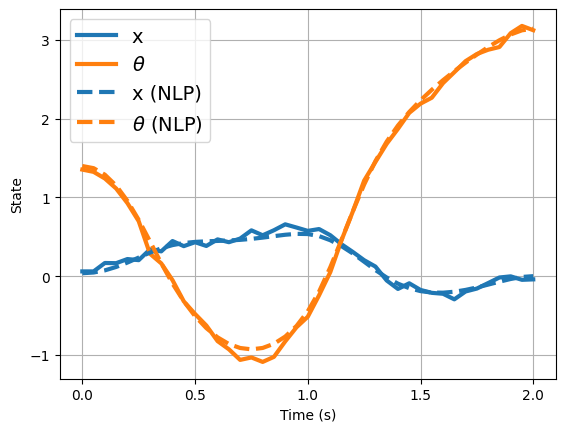

In [19]:
from utils.trajectory_utils import create_idx
nx, nu, N = 4, 1, 41
# nx, nu, N, nz, nc, x, u, c= create_idx(nx, nu, N)
idx = create_idx(nx, nu, N)

t_vec = np.linspace(0, 2, N)

print(test_data.df.iloc[2].solve_time_sec)

print(idx)
plt.plot(t_vec, Z[idx.X][:,:2], linewidth=3.0)
plt.plot(t_vec, test_data.df.iloc[1].X[:,0], '--', linewidth=3.0, color='tab:blue')
plt.plot(t_vec, test_data.df.iloc[1].X[:,1], '--', linewidth=3.0, color='tab:orange')

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

plt.grid(True)
mpl.rc('font', **font)

plt.xlabel('Time (s)')
plt.ylabel('State')
plt.legend(['x', r'$\theta$', 'x (NLP)', r'$\theta$ (NLP)'])

In [21]:
print(idx.X)

[array([0, 1, 2, 3]), array([5, 6, 7, 8]), array([10, 11, 12, 13]), array([15, 16, 17, 18]), array([20, 21, 22, 23]), array([25, 26, 27, 28]), array([30, 31, 32, 33]), array([35, 36, 37, 38]), array([40, 41, 42, 43]), array([45, 46, 47, 48]), array([50, 51, 52, 53]), array([55, 56, 57, 58]), array([60, 61, 62, 63]), array([65, 66, 67, 68]), array([70, 71, 72, 73]), array([75, 76, 77, 78]), array([80, 81, 82, 83]), array([85, 86, 87, 88]), array([90, 91, 92, 93]), array([95, 96, 97, 98]), array([100, 101, 102, 103]), array([105, 106, 107, 108]), array([110, 111, 112, 113]), array([115, 116, 117, 118]), array([120, 121, 122, 123]), array([125, 126, 127, 128]), array([130, 131, 132, 133]), array([135, 136, 137, 138]), array([140, 141, 142, 143]), array([145, 146, 147, 148]), array([150, 151, 152, 153]), array([155, 156, 157, 158]), array([160, 161, 162, 163]), array([165, 166, 167, 168]), array([170, 171, 172, 173]), array([175, 176, 177, 178]), array([180, 181, 182, 183]), array([185, 18

## Go through the test dataset and store the MLP generated warmstart trajectories

In [36]:
warmstart_df = test_data.df.copy()
warmstart_df.shape

warmstart_df['X_warmstart'] = None
warmstart_df['U_warmstart'] = None
warmstart_df['Z_warmstart'] = None

warmstart_df['inference_time_sec'] = None



# warmstart_df.head()
for index, row in warmstart_df.iterrows():
    test_param  = torch.from_numpy(row.params)
    test_param = test_param.to(device)
    
    with torch.no_grad():
        start = time.process_time()
        Z = model(test_param)
        end = time.process_time()
    Z = Z.detach().cpu().numpy()

    warmstart_df.at[index, 'inference_time_sec'] = end - start
    # print(type(Z[idx.X]))
    warmstart_df.at[index, 'X_warmstart'] = Z[idx.X]
    warmstart_df.at[index, 'U_warmstart'] = Z[idx.U]
    print(Z.shape)
    warmstart_df.at[index, 'Z_warmstart'] = Z

    # warmstart_df.['inference_time_sec'] = end-start
    # row['X_warmstart'] = Z[idx.X]
    # row['U_warmstart'] = Z[idx.U]
    # print(row)


warmstart_df.head()



(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)
(204,)

,params,X,U,obj,solve_time_sec,term_status,X_warmstart,U_warmstart,Z_warmstart,inference_time_sec
1826,"[0.19927050795585702, 0.30560027123739736]","[[0.19927050795585702, 0.30560027123739736, 0....","[[4.624766020526614], [3.7150142900837873], [3...",403.873641,1.161033,LOCALLY_SOLVED,"[[0.17014038177457444, 0.3197183089026185, -0....","[[6.317622762726378], [4.709280773573871], [3....","[0.17014038177457444, 0.3197183089026185, -0.0...",0.0
4233,"[0.03700828967086683, 1.3984284368214417]","[[0.03700828967086683, 1.3984284368214417, 0.0...","[[8.563937999558723], [7.437770573144867], [5....",509.821580,0.878283,LOCALLY_SOLVED,"[[0.060329461838231284, 1.3530448090633784, 0....","[[8.103925259455073], [6.250883104680437], [3....","[0.060329461838231284, 1.3530448090633784, 0.0...",0.0
3114,"[0.09979782232967992, 1.2316853395256937]","[[0.09979782232967992, 1.2316853395256937, -7....","[[8.547707114699424], [6.669486249781027], [4....",487.379558,0.776175,LOCALLY_SOLVED,"[[0.06702745576638663, 1.2304274142127474, 0.0...","[[7.765116278919022], [6.000296368447923], [3....","[0.06702745576638663, 1.2304274142127474, 0.04...",0.0
2366,"[0.1667736845602924, 0.16362577304598577]","[[0.1667736845602924, 0.16362577304598577, 0.0...","[[7.222161307942146], [6.082617023519561], [5....",398.681969,1.518023,LOCALLY_SOLVED,"[[0.1716985470175058, 0.1649060962141866, -0.0...","[[6.04255706282113], [4.4737675359014], [3.523...","[0.1716985470175058, 0.1649060962141866, -0.07...",0.0
3094,"[0.08334178987275496, 1.0506542569203796]","[[0.08334178987275496, 1.0506542569203796, 0.0...","[[7.722883022387507], [5.334875617800323], [2....",464.931622,0.636347,LOCALLY_SOLVED,"[[0.07857697360853633, 1.0720784614496655, 0.0...","[[7.438125878040006], [5.692078030610056], [3....","[0.07857697360853633, 1.0720784614496655, 0.01...",0.0


In [34]:
warmstart_df.to_csv('data/warmstart_cartpole.csv')


## Visualize histograms for solve time

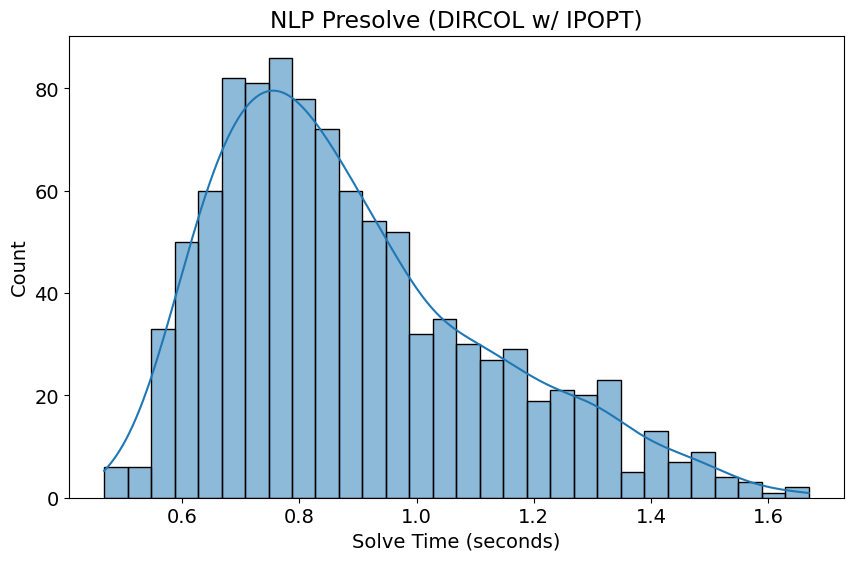

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(warmstart_df['solve_time_sec'], bins=30, kde=True)
plt.xlabel('Solve Time (seconds)')
plt.ylabel('Count')
plt.title('NLP Presolve (DIRCOL w/ IPOPT)')
plt.show()

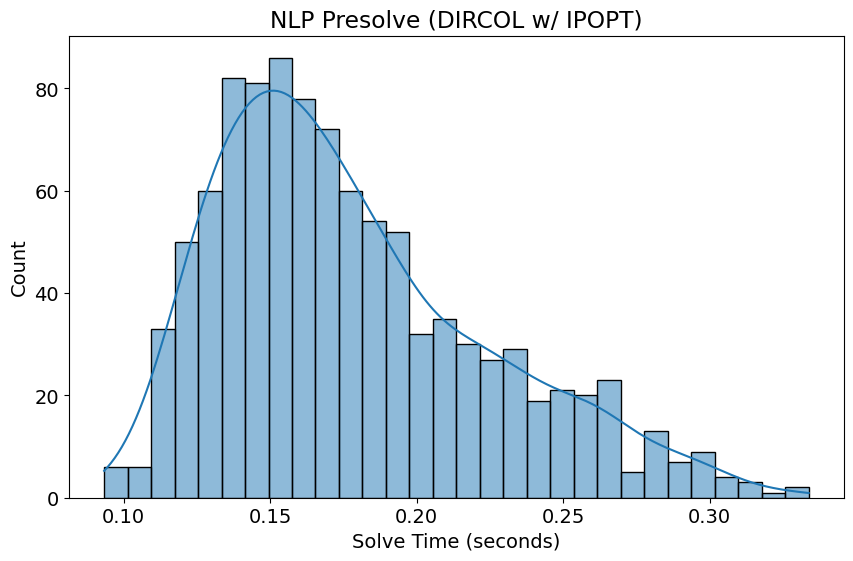

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(warmstart_df['solve_time_sec']/5, bins=30, kde=True)
plt.xlabel('Solve Time (seconds)')
plt.ylabel('Count')
plt.title('NLP Presolve (DIRCOL w/ IPOPT)')
plt.show()